In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [3]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037446 entries, 0 to 2037445
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 31.1 MB


# reduce to 1 million events

In [4]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [5]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,5319,0.68,5.319
1,5337,0.67,5.337
2,5332,0.68,5.332
3,5332,0.68,5.332
4,5786,0.62,5.786
...,...,...,...
999995,16978,0.21,16.978
999996,17049,0.21,17.049
999997,17044,0.21,17.044
999998,17024,0.21,17.024


In [6]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [7]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [8]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26036747177000

### Calcul de la date de base = now - cumul_interval

In [9]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 5, 23, 12, 42, 38, 293913)

In [10]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [11]:
conso_data.iloc[0]


Interval     5319.000000
kWh             0.680000
sec             5.319000
Wh            676.818951
cumul(ms)    5319.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [12]:
base

datetime.datetime(2024, 5, 23, 12, 42, 38, 293913)

## créer les dates

In [13]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-05-23 12:42:43.612913
1        2024-05-23 12:42:48.949913
2        2024-05-23 12:42:54.281913
3        2024-05-23 12:42:59.613913
4        2024-05-23 12:43:05.399913
                    ...            
999995   2025-03-20 21:07:17.430913
999996   2025-03-20 21:07:34.479913
999997   2025-03-20 21:07:51.523913
999998   2025-03-20 21:08:08.547913
999999   2025-03-20 21:08:25.470913
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [14]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,5319,0.68,5.319,676.818951,5319,2024-05-23 12:42:43.612913,23/05/24
1,5337,0.67,5.337,674.536256,10656,2024-05-23 12:42:48.949913,23/05/24
2,5332,0.68,5.332,675.168792,15988,2024-05-23 12:42:54.281913,23/05/24
3,5332,0.68,5.332,675.168792,21320,2024-05-23 12:42:59.613913,23/05/24
4,5786,0.62,5.786,622.191497,27106,2024-05-23 12:43:05.399913,23/05/24
...,...,...,...,...,...,...,...
999995,16978,0.21,16.978,212.039109,26036679137,2025-03-20 21:07:17.430913,20/03/25
999996,17049,0.21,17.049,211.156080,26036696186,2025-03-20 21:07:34.479913,20/03/25
999997,17044,0.21,17.044,211.218024,26036713230,2025-03-20 21:07:51.523913,20/03/25
999998,17024,0.21,17.024,211.466165,26036730254,2025-03-20 21:08:08.547913,20/03/25


### save conso_data with dates

In [15]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [16]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('20/03/25', 20, 3, 2025)

In [17]:
here = now.strftime('%H:%M:%S')
here

'21:08:38'

In [18]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [19]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 997081 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2919 non-null   int64         
 1   kWh        2919 non-null   float64       
 2   sec        2919 non-null   float64       
 3   Wh         2919 non-null   float64       
 4   cumul(ms)  2919 non-null   int64         
 5   dates      2919 non-null   datetime64[ns]
 6   days       2919 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 182.4+ KB


In [20]:
end = time.time()
print(end - start)

14.276528358459473


### grouped by days

In [21]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [22]:
data = list(df_grp['kWh'])
print(data)

[1.587, 4.374, 3.671, 3.65, 3.772, 3.56, 3.093, 3.273, 4.143, 3.603, 4.264, 3.561, 3.315, 3.484, 3.181, 2.934, 3.413, 3.173, 3.307, 3.731, 3.361, 3.342, 3.095, 2.959, 3.695, 3.216, 3.125, 3.255, 3.357, 2.983, 3.037, 3.49, 3.688, 3.44, 3.045, 2.883, 2.079, 2.093, 2.084, 2.081, 2.086, 2.086, 2.076, 2.076, 2.117, 3.662, 3.131, 3.468, 3.792, 3.608, 3.794, 3.561, 3.657, 3.587, 3.486, 3.388, 3.283, 3.471, 3.288, 3.759, 3.672, 3.566, 3.597, 3.423, 3.23, 3.202, 2.858, 3.029, 3.69, 3.786, 3.761, 3.011, 3.359, 3.36, 3.511, 3.66, 3.697, 3.544, 3.703, 3.867, 3.803, 4.366, 4.215, 3.841, 3.971, 3.982, 3.827, 3.856, 3.708, 3.257, 3.969, 3.958, 4.41, 3.743, 4.183, 3.737, 3.967, 3.825, 3.898, 3.734, 3.591, 3.515, 3.706, 3.533, 4.064, 3.767, 3.39, 3.484, 3.296, 2.326, 1.795, 1.794, 1.792, 1.796, 2.529, 1.808, 1.789, 1.79, 1.792, 1.822, 1.822, 1.813, 1.817, 1.818, 1.819, 1.817, 1.81, 1.785, 1.787, 1.784, 1.786, 1.784, 1.796, 1.788, 1.789, 1.785, 1.796, 1.804, 1.794, 1.806, 1.794, 1.784, 1.79, 1.786, 1.78

In [23]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [24]:
end = time.time()
print(end - start)

14.484773397445679


### plot function by day
#### show('dd/mm/yy')

In [25]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


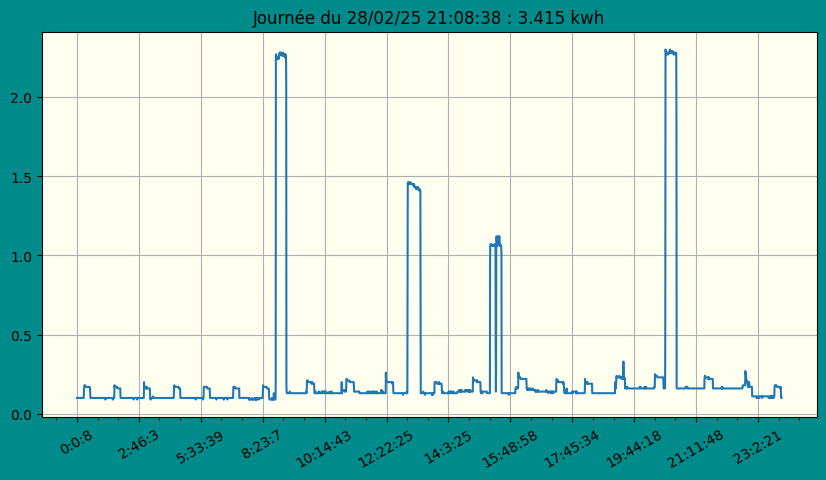

In [26]:
show('28/02/25')

In [27]:
end = time.time()
print(end - start)

15.6059889793396


### 1 kWh window in data of one day
#### df = conso_day

In [28]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997081,18159,0.20,18.159,198.248802,25960643975,2025-03-20 00:00:02.268913,20/03/25
997082,18005,0.20,18.005,199.944460,25960661980,2025-03-20 00:00:20.273913,20/03/25
997083,17291,0.21,17.291,208.200798,25960679271,2025-03-20 00:00:37.564913,20/03/25
997084,17699,0.20,17.699,203.401322,25960696970,2025-03-20 00:00:55.263913,20/03/25
997085,17741,0.20,17.741,202.919790,25960714711,2025-03-20 00:01:13.004913,20/03/25
...,...,...,...,...,...,...,...
999995,16978,0.21,16.978,212.039109,26036679137,2025-03-20 21:07:17.430913,20/03/25
999996,17049,0.21,17.049,211.156080,26036696186,2025-03-20 21:07:34.479913,20/03/25
999997,17044,0.21,17.044,211.218024,26036713230,2025-03-20 21:07:51.523913,20/03/25
999998,17024,0.21,17.024,211.466165,26036730254,2025-03-20 21:08:08.547913,20/03/25


In [29]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [30]:
df = conso_day
len(df)

2919

In [31]:
period()  # first kWh

2025-03-20 00:00:02.268913	2025-03-20 08:10:12.489913	8h 10m 10s 	1000


In [32]:
period(p=2) # second period

2025-03-20 08:10:12.489913	2025-03-20 14:53:02.376913	6h 42m 49s 	2000


In [33]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.289163
dtype: float64

In [34]:
end = time.time()
print(end - start)

15.803765535354614


## mean for data grouped by days

In [35]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.311258
dtype: float64

In [36]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(2.919)

# conso by date


In [37]:
# select day
day = today

#day = '16/08/24'
day

'20/03/25'

In [38]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997081,18159,0.20,18.159,198.248802,25960643975,2025-03-20 00:00:02.268913,20/03/25
997082,18005,0.20,18.005,199.944460,25960661980,2025-03-20 00:00:20.273913,20/03/25
997083,17291,0.21,17.291,208.200798,25960679271,2025-03-20 00:00:37.564913,20/03/25
997084,17699,0.20,17.699,203.401322,25960696970,2025-03-20 00:00:55.263913,20/03/25
997085,17741,0.20,17.741,202.919790,25960714711,2025-03-20 00:01:13.004913,20/03/25
...,...,...,...,...,...,...,...
999995,16978,0.21,16.978,212.039109,26036679137,2025-03-20 21:07:17.430913,20/03/25
999996,17049,0.21,17.049,211.156080,26036696186,2025-03-20 21:07:34.479913,20/03/25
999997,17044,0.21,17.044,211.218024,26036713230,2025-03-20 21:07:51.523913,20/03/25
999998,17024,0.21,17.024,211.466165,26036730254,2025-03-20 21:08:08.547913,20/03/25


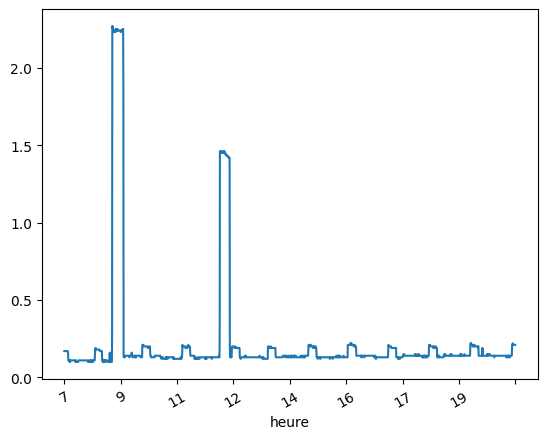

In [39]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [40]:
end = time.time()
print(end - start)

16.34748673439026


### grouped by 'heure'

In [41]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 997081 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2919 non-null   int64         
 1   kWh        2919 non-null   float64       
 2   sec        2919 non-null   float64       
 3   Wh         2919 non-null   float64       
 4   cumul(ms)  2919 non-null   int64         
 5   dates      2919 non-null   datetime64[ns]
 6   days       2919 non-null   object        
 7   heure      2919 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 205.2+ KB


In [42]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,18159,0.20,18.159,198.248802,25960643975,2025-03-20 00:00:02.268913,20/03/25
0,18005,0.20,18.005,199.944460,25960661980,2025-03-20 00:00:20.273913,20/03/25
0,17291,0.21,17.291,208.200798,25960679271,2025-03-20 00:00:37.564913,20/03/25
0,17699,0.20,17.699,203.401322,25960696970,2025-03-20 00:00:55.263913,20/03/25
0,17741,0.20,17.741,202.919790,25960714711,2025-03-20 00:01:13.004913,20/03/25
...,...,...,...,...,...,...,...
21,16978,0.21,16.978,212.039109,26036679137,2025-03-20 21:07:17.430913,20/03/25
21,17049,0.21,17.049,211.156080,26036696186,2025-03-20 21:07:34.479913,20/03/25
21,17044,0.21,17.044,211.218024,26036713230,2025-03-20 21:07:51.523913,20/03/25


In [43]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [44]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     140
1     123
2     123
3     122
4     120
5     112
6     121
7     120
8     120
9     180
10    136
11    141
12    183
13    139
14    143
15    134
16    150
17    145
18    149
19    152
20    141
21     25
Name: kWh, dtype: int64

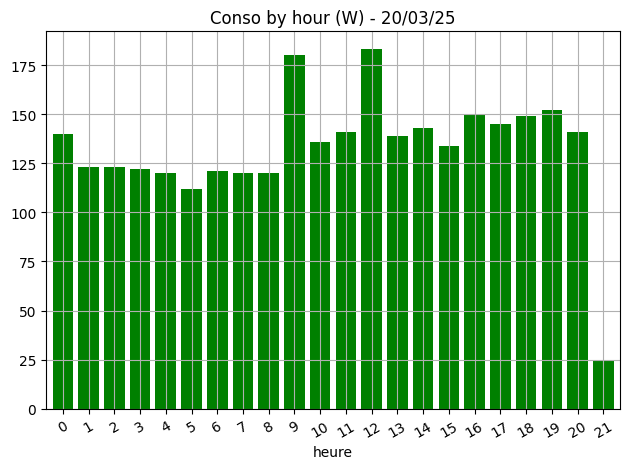

In [45]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [46]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 23/05/24 to 20/03/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     302 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [47]:
# give the periods of 1 kwh in a day
period()

2025-03-20 00:00:02.268913	2025-03-20 08:10:12.489913	8h 10m 10s 	1000


In [48]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-03-20 00:00:02.268913'),
 Timestamp('2025-03-20 08:10:45.869913'))

In [49]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [50]:
df_grp.mean()


kWh    3.311258
dtype: float64

In [51]:
df_grp.head()


,kWh
days,
23/05/24,1.587
24/05/24,4.374
25/05/24,3.671
26/05/24,3.650
27/05/24,3.772


In [52]:
df_grp.tail()


,kWh
days,
16/03/25,3.098
17/03/25,3.080
18/03/25,3.395
19/03/25,3.965
20/03/25,2.919


In [53]:
end = time.time()
print(end - start)

17.13681697845459


# plot les 100 derniers jours


In [54]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.68423
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

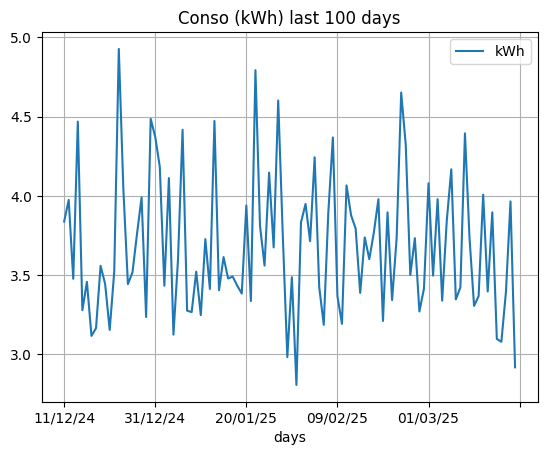

In [55]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [56]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.808
max,4.926


In [57]:
end = time.time()
print(end - start)

17.596467971801758


Text(0.5, 1.0, 'Last month conso by day')

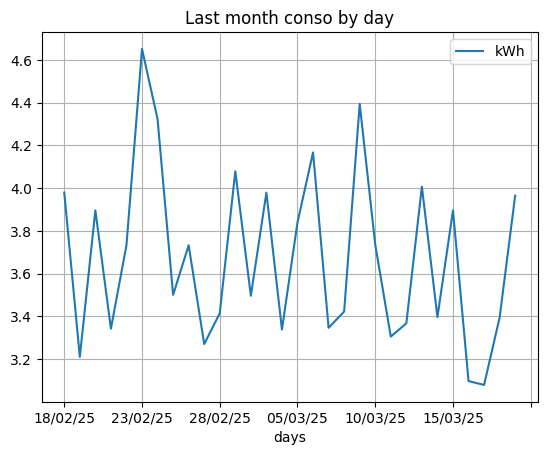

In [58]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [59]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/02/25 4.651
Min : 17/03/25 3.08


In [60]:

tranches = len(df)//1000
tranches+1


3

In [61]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-03-20 00:00:02.268913	2025-03-20 08:10:12.489913	8h 10m 10s 	1000
2025-03-20 08:10:12.489913	2025-03-20 14:53:02.376913	6h 42m 49s 	2000
2025-03-20 14:53:02.376913	2025-03-20 21:08:25.470913	6h 15m 23s 	919


('21:08:38', 2.919, 2919)

In [62]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 997081 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2919 non-null   int64         
 1   kWh        2919 non-null   float64       
 2   sec        2919 non-null   float64       
 3   Wh         2919 non-null   float64       
 4   cumul(ms)  2919 non-null   int64         
 5   dates      2919 non-null   datetime64[ns]
 6   days       2919 non-null   object        
 7   heure      2919 non-null   object        
 8   hours      2919 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 228.0+ KB


In [63]:
conso_hours['heure'], conso_hours['hours']

(997081     0
 997082     0
 997083     0
 997084     0
 997085     0
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: heure, Length: 2919, dtype: object,
 997081    00
 997082    00
 997083    00
 997084    00
 997085    00
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: hours, Length: 2919, dtype: object)

In [64]:
end = time.time()
print(end - start)

18.26595664024353


# select number of days to display


In [65]:
span = 30
#df_grp.tail(span)

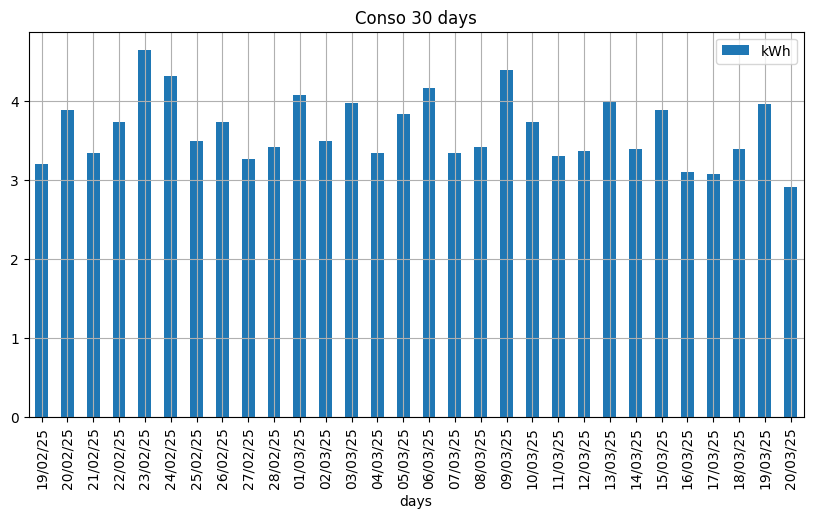

In [66]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


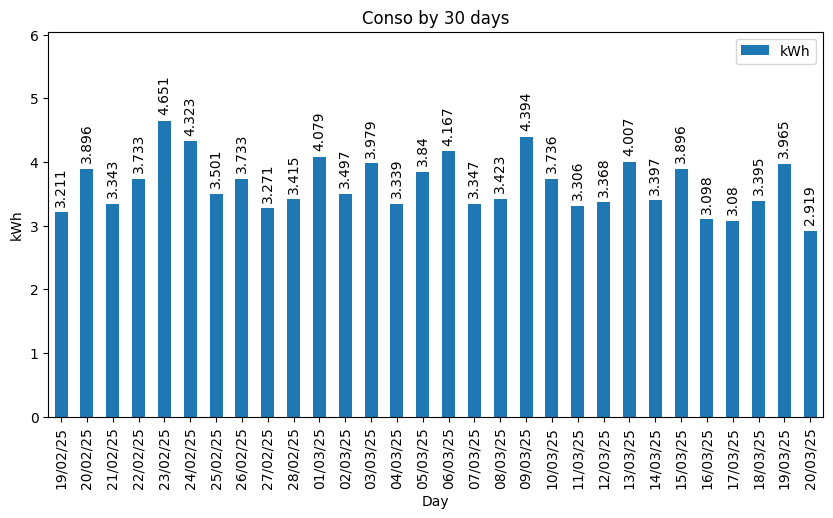

In [67]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [68]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
19/02/25    3.211
20/02/25    3.896
21/02/25    3.343
22/02/25    3.733
23/02/25    4.651
24/02/25    4.323
25/02/25    3.501
26/02/25    3.733
27/02/25    3.271
28/02/25    3.415
01/03/25    4.079
02/03/25    3.497
03/03/25    3.979
04/03/25    3.339
05/03/25    3.840
06/03/25    4.167
07/03/25    3.347
08/03/25    3.423
09/03/25    4.394
10/03/25    3.736
11/03/25    3.306
12/03/25    3.368
13/03/25    4.007
14/03/25    3.397
15/03/25    3.896
16/03/25    3.098
17/03/25    3.080
18/03/25    3.395
19/03/25    3.965
20/03/25    2.919
Name: kWh, dtype: float64

In [69]:
x_labels=df_grp.tail(span).index
x_labels

Index(['19/02/25', '20/02/25', '21/02/25', '22/02/25', '23/02/25', '24/02/25',
       '25/02/25', '26/02/25', '27/02/25', '28/02/25', '01/03/25', '02/03/25',
       '03/03/25', '04/03/25', '05/03/25', '06/03/25', '07/03/25', '08/03/25',
       '09/03/25', '10/03/25', '11/03/25', '12/03/25', '13/03/25', '14/03/25',
       '15/03/25', '16/03/25', '17/03/25', '18/03/25', '19/03/25', '20/03/25'],
      dtype='object', name='days')

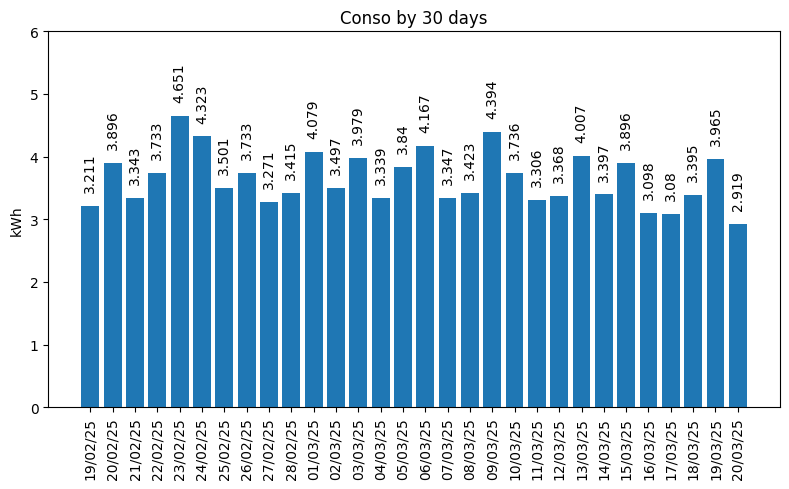

In [70]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [71]:
end = time.time()
print(end - start)

21.213755130767822


In [72]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

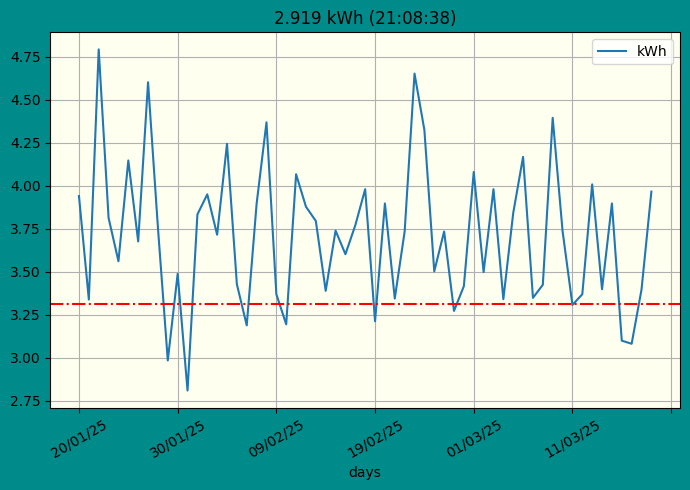

In [73]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")


df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

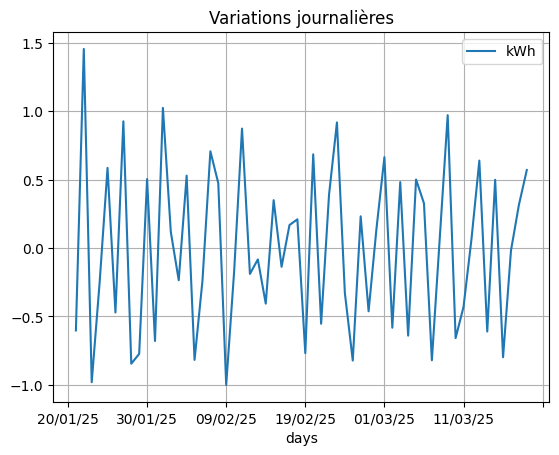

In [74]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [75]:
end = time.time()
print(end - start)

22.039856433868408


# Data from 21/08/23

In [76]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,5319,0.68,5.319,676.818951,5319,2024-05-23 12:42:43.612913,23/05/24,12,2024-05,23
1,5337,0.67,5.337,674.536256,10656,2024-05-23 12:42:48.949913,23/05/24,12,2024-05,23
2,5332,0.68,5.332,675.168792,15988,2024-05-23 12:42:54.281913,23/05/24,12,2024-05,23
3,5332,0.68,5.332,675.168792,21320,2024-05-23 12:42:59.613913,23/05/24,12,2024-05,23
4,5786,0.62,5.786,622.191497,27106,2024-05-23 12:43:05.399913,23/05/24,12,2024-05,23
...,...,...,...,...,...,...,...,...,...,...
999995,16978,0.21,16.978,212.039109,26036679137,2025-03-20 21:07:17.430913,20/03/25,21,2025-03,20
999996,17049,0.21,17.049,211.156080,26036696186,2025-03-20 21:07:34.479913,20/03/25,21,2025-03,20
999997,17044,0.21,17.044,211.218024,26036713230,2025-03-20 21:07:51.523913,20/03/25,21,2025-03,20
999998,17024,0.21,17.024,211.466165,26036730254,2025-03-20 21:08:08.547913,20/03/25,21,2025-03,20


In [77]:
end = time.time()
print(end - start)

57.66663217544556


In [78]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'])

# define month to show

In [79]:
month=conso_grouped_by_month.get_group('2025-02')

In [80]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

<Axes: xlabel='day'>

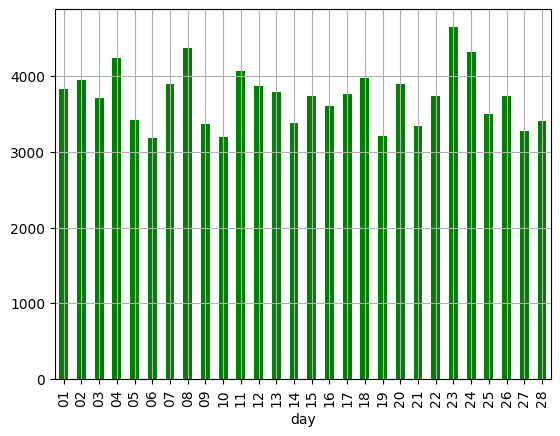

In [81]:
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

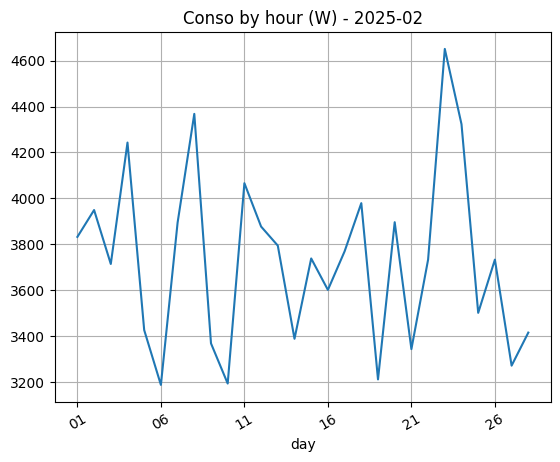

In [82]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [83]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [84]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3832,3832,3832
02,3949,3949,3949
03,3714,3714,3714
04,4243,4243,4243
05,3426,3426,3426
06,3187,3187,3187
07,3894,3894,3894
08,4368,4368,4368
09,3368,3368,3368


In [85]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [86]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [87]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-05,31123,31123,31123
2024-06,96193,96193,96193
2024-07,99510,99510,99510
2024-08,117314,117314,117314
2024-09,69646,69646,69646
2024-10,73693,73693,73693
2024-11,108461,108461,108461
2024-12,113868,113868,113868
2025-01,113497,113497,113497


In [88]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [89]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [90]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
23/05/24,1587
24/05/24,4374
25/05/24,3671
26/05/24,3650
27/05/24,3772
...,...
16/03/25,3098
17/03/25,3080
18/03/25,3395


In [91]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,5319,0.68,5.319,676.818951,5319,2024-05-23 12:42:43.612913,23/05/24,12,2024-05,23
1,5337,0.67,5.337,674.536256,10656,2024-05-23 12:42:48.949913,23/05/24,12,2024-05,23
2,5332,0.68,5.332,675.168792,15988,2024-05-23 12:42:54.281913,23/05/24,12,2024-05,23
3,5332,0.68,5.332,675.168792,21320,2024-05-23 12:42:59.613913,23/05/24,12,2024-05,23
4,5786,0.62,5.786,622.191497,27106,2024-05-23 12:43:05.399913,23/05/24,12,2024-05,23
...,...,...,...,...,...,...,...,...,...,...
999995,16978,0.21,16.978,212.039109,26036679137,2025-03-20 21:07:17.430913,20/03/25,21,2025-03,20
999996,17049,0.21,17.049,211.156080,26036696186,2025-03-20 21:07:34.479913,20/03/25,21,2025-03,20
999997,17044,0.21,17.044,211.218024,26036713230,2025-03-20 21:07:51.523913,20/03/25,21,2025-03,20
999998,17024,0.21,17.024,211.466165,26036730254,2025-03-20 21:08:08.547913,20/03/25,21,2025-03,20


In [92]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
23/05/24 12    0       23/05/24    12  0.68
               1       23/05/24    12  0.67
               2       23/05/24    12  0.68
               3       23/05/24    12  0.68
               4       23/05/24    12  0.62
...                         ...   ...   ...
20/03/25 21    999995  20/03/25    21  0.21
               999996  20/03/25    21  0.21
               999997  20/03/25    21  0.21
               999998  20/03/25    21  0.21
               999999  20/03/25    21  0.21

[1000000 rows x 3 columns]

In [93]:
groupallbyday.indices.keys()

dict_keys(['23/05/24', '24/05/24', '25/05/24', '26/05/24', '27/05/24', '28/05/24', '29/05/24', '30/05/24', '31/05/24', '01/06/24', '02/06/24', '03/06/24', '04/06/24', '05/06/24', '06/06/24', '07/06/24', '08/06/24', '09/06/24', '10/06/24', '11/06/24', '12/06/24', '13/06/24', '14/06/24', '15/06/24', '16/06/24', '17/06/24', '18/06/24', '19/06/24', '20/06/24', '21/06/24', '22/06/24', '23/06/24', '24/06/24', '25/06/24', '26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/0

In [94]:
groupallbydayhours.indices.keys()

dict_keys([('23/05/24', '12'), ('23/05/24', '13'), ('23/05/24', '14'), ('23/05/24', '15'), ('23/05/24', '16'), ('23/05/24', '17'), ('23/05/24', '18'), ('23/05/24', '19'), ('23/05/24', '20'), ('23/05/24', '21'), ('23/05/24', '22'), ('23/05/24', '23'), ('24/05/24', '12'), ('24/05/24', '13'), ('24/05/24', '14'), ('24/05/24', '15'), ('24/05/24', '16'), ('24/05/24', '17'), ('24/05/24', '18'), ('24/05/24', '19'), ('24/05/24', '20'), ('24/05/24', '21'), ('24/05/24', '22'), ('24/05/24', '23'), ('24/05/24', '00'), ('24/05/24', '01'), ('24/05/24', '02'), ('24/05/24', '03'), ('24/05/24', '04'), ('24/05/24', '05'), ('24/05/24', '06'), ('24/05/24', '07'), ('24/05/24', '08'), ('24/05/24', '09'), ('24/05/24', '10'), ('24/05/24', '11'), ('25/05/24', '12'), ('25/05/24', '13'), ('25/05/24', '14'), ('25/05/24', '15'), ('25/05/24', '16'), ('25/05/24', '17'), ('25/05/24', '18'), ('25/05/24', '19'), ('25/05/24', '20'), ('25/05/24', '21'), ('25/05/24', '22'), ('25/05/24', '23'), ('25/05/24', '00'), ('25/05/2

In [95]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
23/05/24,1587,1587
24/05/24,4374,4374
25/05/24,3671,3671
26/05/24,3650,3650
27/05/24,3772,3772
...,...,...
16/03/25,3098,3098
17/03/25,3080,3080
18/03/25,3395,3395


In [96]:
grp_by_day['kWh'].cumsum()

days
23/05/24       1587
24/05/24       5961
25/05/24       9632
26/05/24      13282
27/05/24      17054
             ...   
16/03/25     986641
17/03/25     989721
18/03/25     993116
19/03/25     997081
20/03/25    1000000
Name: kWh, Length: 302, dtype: int64

In [97]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
23/05/24 12      72
         13     133
         14     132
         15     131
         16     136
...             ...
20/03/25 17     145
         18     149
         19     152
         20     141
         21      25

[7234 rows x 1 columns]

In [98]:
grp_by_dayhours['kWh'].cumsum()

days      hours
23/05/24  12            72
          13           205
          14           337
          15           468
          16           604
                    ...   
20/03/25  17        999533
          18        999682
          19        999834
          20        999975
          21       1000000
Name: kWh, Length: 7234, dtype: int64

In [99]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
23/05/24 12      72      72    NaN
         13     133     205   61.0
         14     132     337   -1.0
         15     131     468   -1.0
         16     136     604    5.0
...             ...     ...    ...
20/03/25 17     145    2452   -5.0
         18     149    2601    4.0
         19     152    2753    3.0
         20     141    2894  -11.0
         21      25    2919 -116.0

[7234 rows x 3 columns]

In [100]:
today, grp_by_dayhours.loc[today]

('20/03/25',
        kWh  cumsum   diff
 hours                    
 00     140     140    NaN
 01     123     263  -17.0
 02     123     386    0.0
 03     122     508   -1.0
 04     120     628   -2.0
 05     112     740   -8.0
 06     121     861    9.0
 07     120     981   -1.0
 08     120    1101    0.0
 09     180    1281   60.0
 10     136    1417  -44.0
 11     141    1558    5.0
 12     183    1741   42.0
 13     139    1880  -44.0
 14     143    2023    4.0
 15     134    2157   -9.0
 16     150    2307   16.0
 17     145    2452   -5.0
 18     149    2601    4.0
 19     152    2753    3.0
 20     141    2894  -11.0
 21      25    2919 -116.0)

Text(0.5, 1.0, 'Cumul journalier')

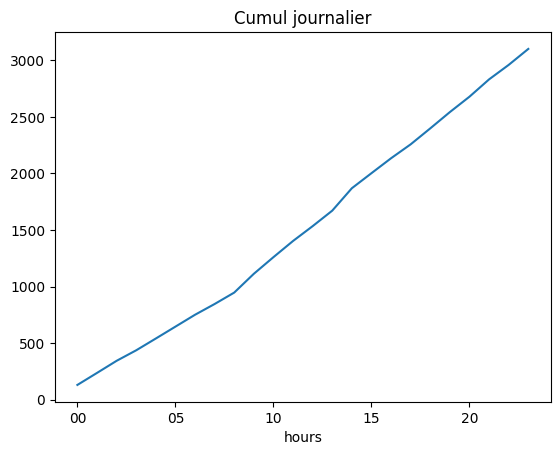

In [101]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

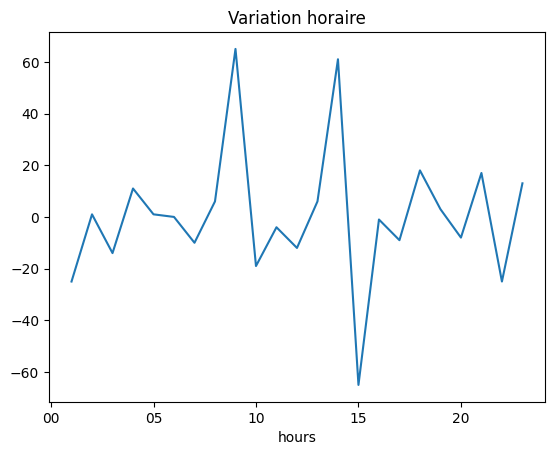

In [102]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [103]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

302

In [104]:
df_grp.tail(n)['kWh'].describe()


count    302.000000
mean       3.311258
std        0.756444
min        1.587000
25%        3.125000
50%        3.484000
75%        3.780500
max        4.926000
Name: kWh, dtype: float64

In [105]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '302 days')

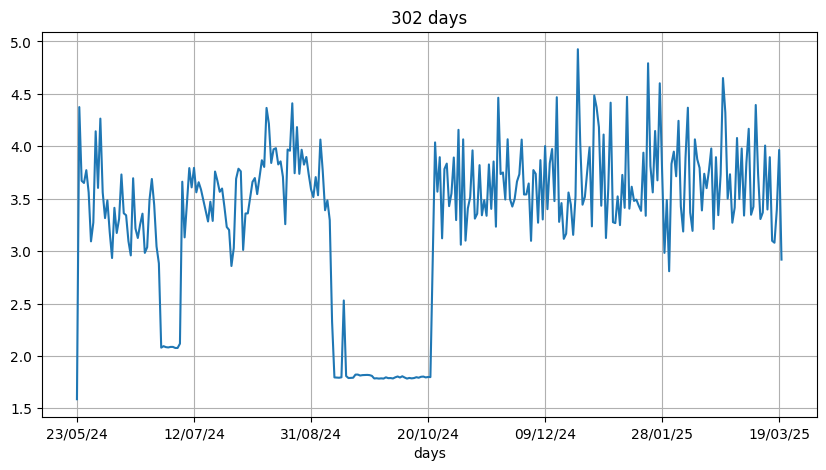

In [106]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

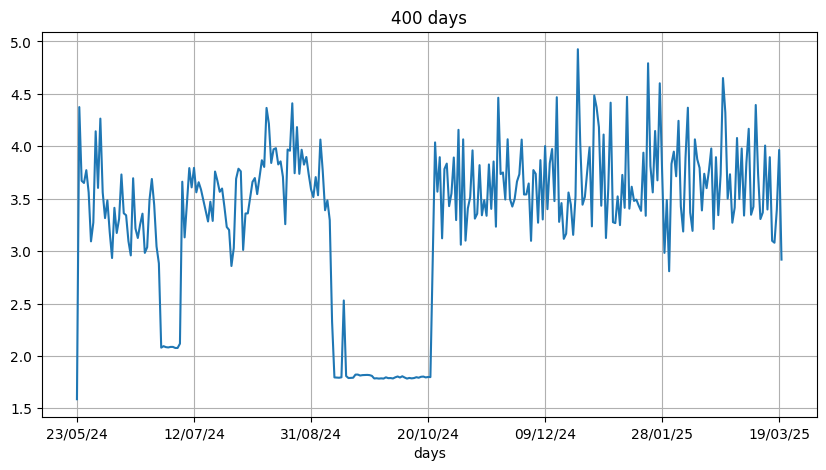

In [107]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [108]:
df_grp['kWh']

days
23/05/24    1.587
24/05/24    4.374
25/05/24    3.671
26/05/24    3.650
27/05/24    3.772
            ...  
16/03/25    3.098
17/03/25    3.080
18/03/25    3.395
19/03/25    3.965
20/03/25    2.919
Name: kWh, Length: 302, dtype: float64

In [109]:
df_grp.describe()

,kWh
count,302.000000
mean,3.311258
std,0.756444
min,1.587000
25%,3.125000
50%,3.484000
75%,3.780500
max,4.926000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

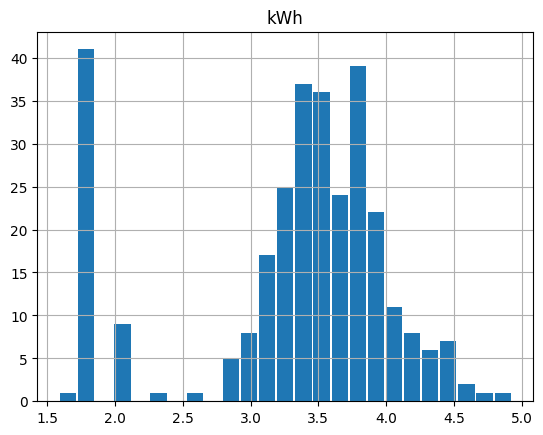

In [110]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [111]:
df_grp.tail(span)['kWh']

days
23/05/24    1.587
24/05/24    4.374
25/05/24    3.671
26/05/24    3.650
27/05/24    3.772
            ...  
16/03/25    3.098
17/03/25    3.080
18/03/25    3.395
19/03/25    3.965
20/03/25    2.919
Name: kWh, Length: 302, dtype: float64

# Conso par heure

In [112]:
day

'20/03/25'

In [113]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,140,140,NaN
01,123,263,-17.0
02,123,386,0.0
03,122,508,-1.0
04,120,628,-2.0
05,112,740,-8.0
06,121,861,9.0
07,120,981,-1.0
08,120,1101,0.0


In [114]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


22

In [115]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 23)

In [116]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [117]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22.])

In [118]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [119]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [120]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 00 to 21
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     22 non-null     int64  
 1   cumsum  22 non-null     int64  
 2   diff    21 non-null     float64
 3   days    22 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 880.0+ bytes


In [121]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [122]:
day

'20/03/25'

In [123]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,140,140,NaN,1.0
01,123,263,-17.0,2.0
02,123,386,0.0,3.0
03,122,508,-1.0,4.0
04,120,628,-2.0,5.0
05,112,740,-8.0,6.0
06,121,861,9.0,7.0
07,120,981,-1.0,8.0
08,120,1101,0.0,9.0


Text(0.5, 1.0, '20/03/25')

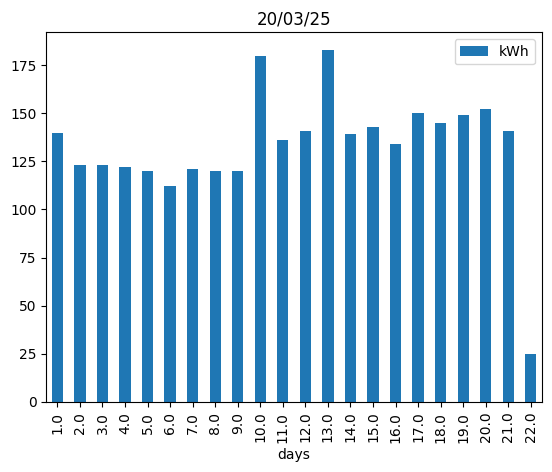

In [124]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [125]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'],
      dtype='object', name='hours')

# Conso du jour


In [126]:

grp_by_dayhours.count()

kWh       7234
cumsum    7234
diff      6932
days        22
dtype: int64

In [127]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00     135
01     133
02     141
03     109
04     106
05     110
06     108
07     108
08     109
09     110
10     105
11     165
12     142
13     139
14     133
15    1112
16     431
17     136
18     213
19     168
20     244
21     244
22     279
23     246
Name: kWh, dtype: int64

In [128]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

            kWh
days           
20/03/25  2.919


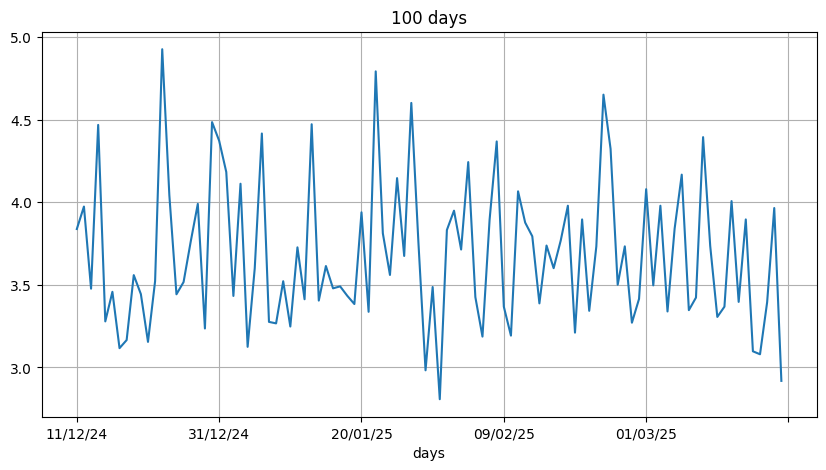

In [129]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])
print(df_grp.tail(1))

In [130]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

73.04243731498718


# Today

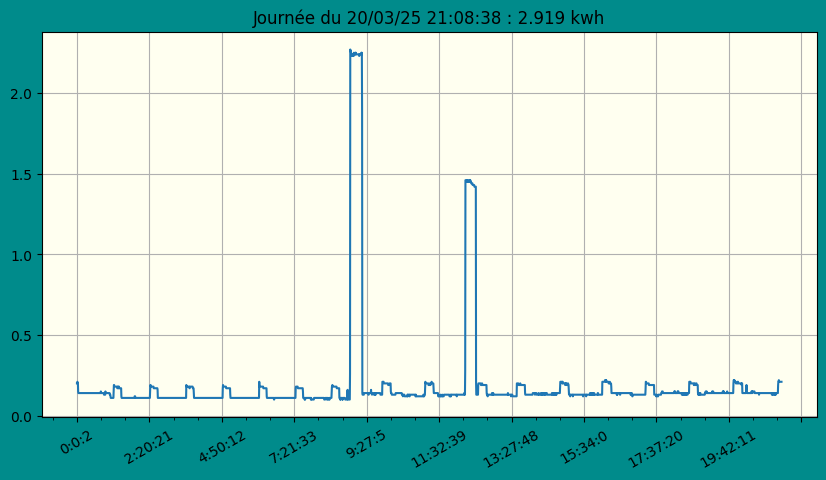

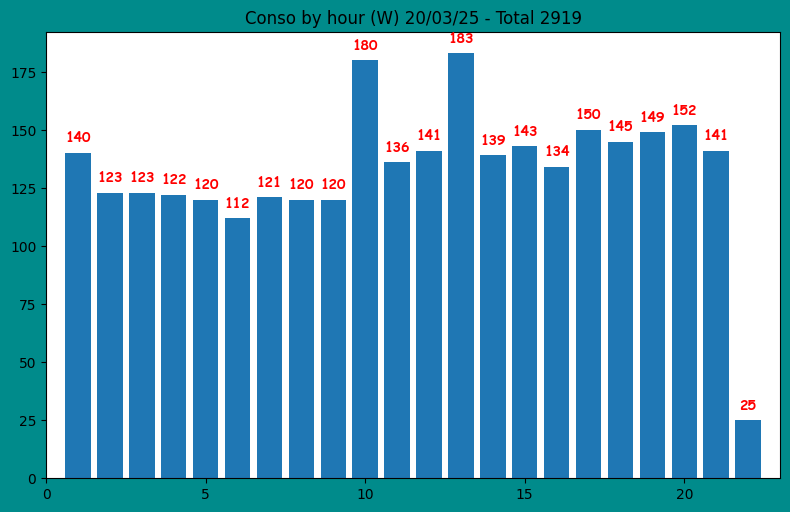

In [131]:
show(today,bgcolor='ivory')
conso_by_hour(today)

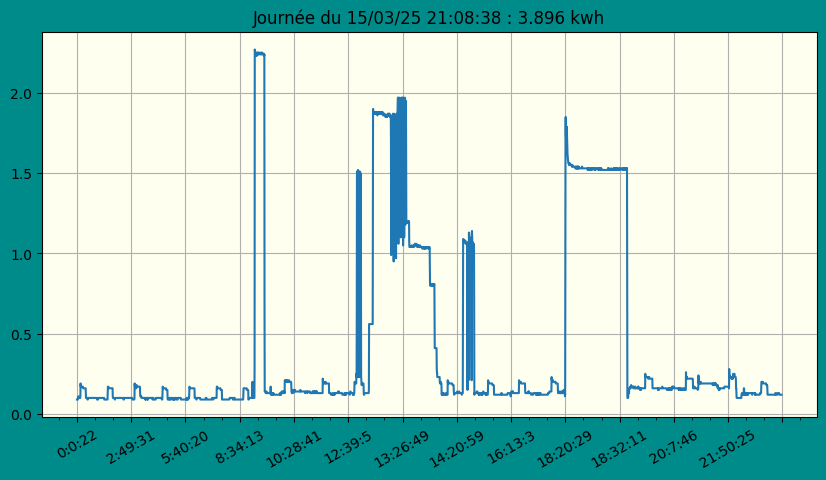

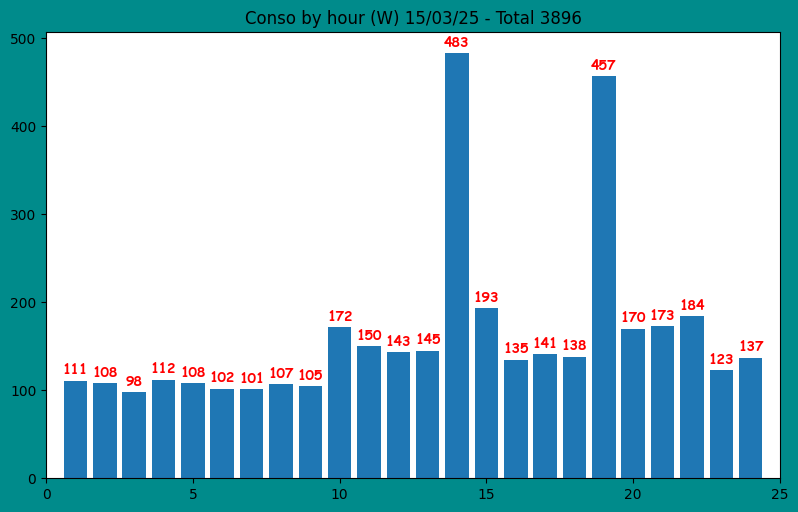

In [132]:
day = '15/03/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

23/12/24


(None, 4926)

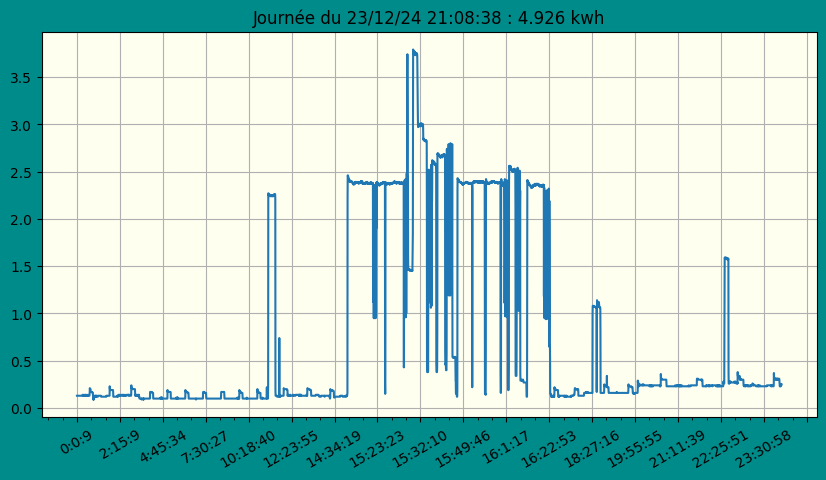

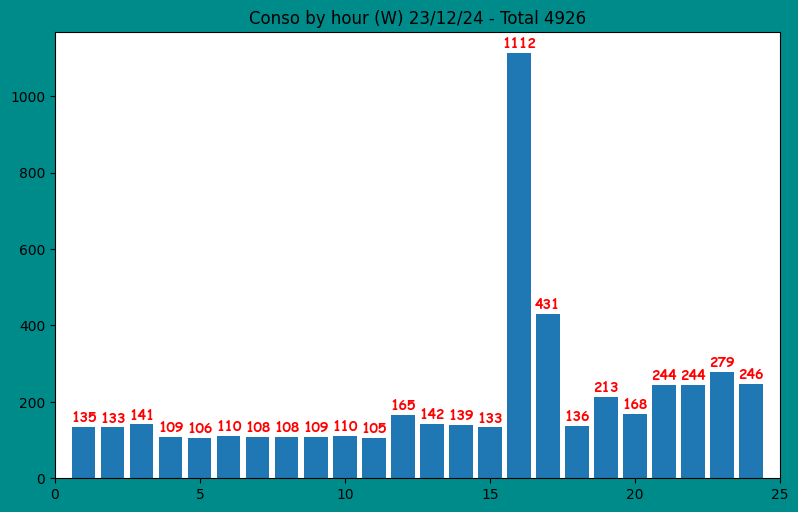

In [133]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

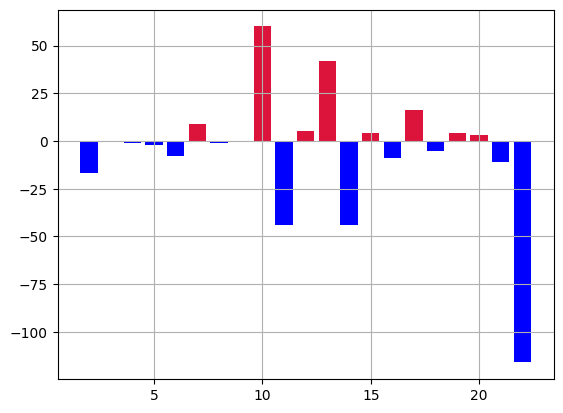

In [134]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

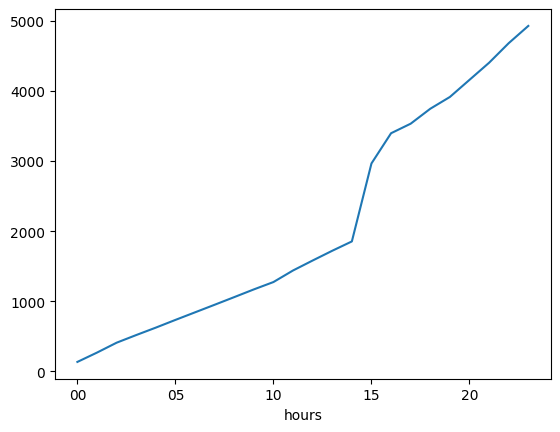

In [135]:
data.cumsum().plot()


<Axes: xlabel='hours'>

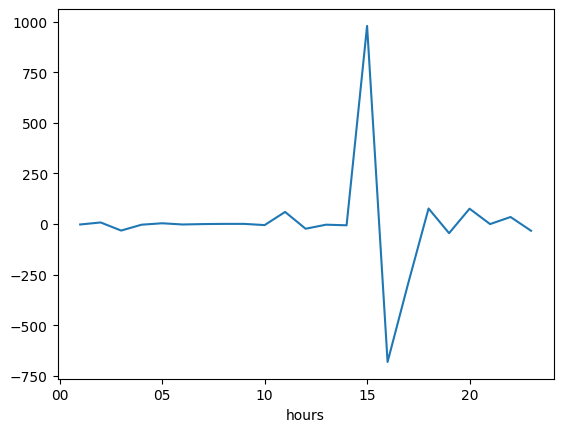

In [136]:
# evolution par heure
data.diff().plot()

In [137]:
data.diff().describe()

count     23.000000
mean       4.826087
std      263.719660
min     -681.000000
25%      -14.500000
50%       -2.000000
75%        6.000000
max      979.000000
Name: kWh, dtype: float64

<Axes: >

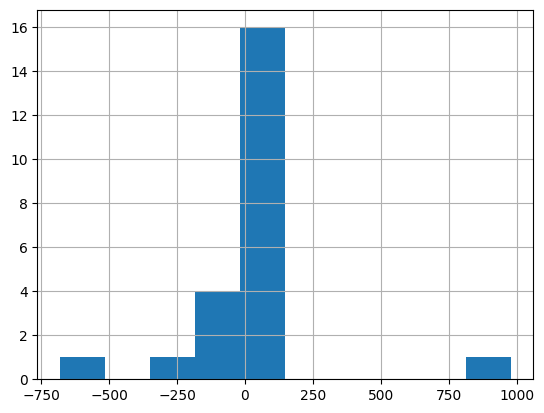

In [138]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [139]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '.vs',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_mini.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptograp

# list store files csv


In [140]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


('23/12/24', None)

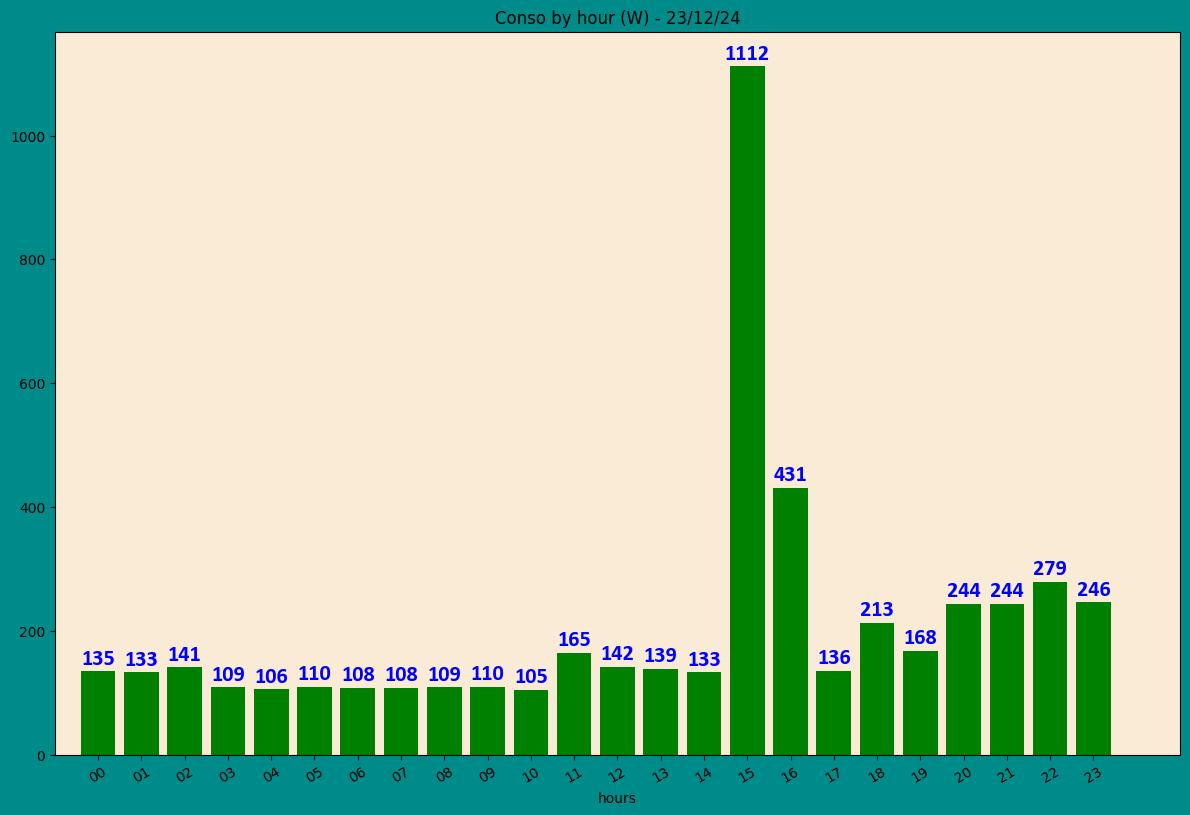

In [141]:
day,conso_byhour(day)

In [142]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


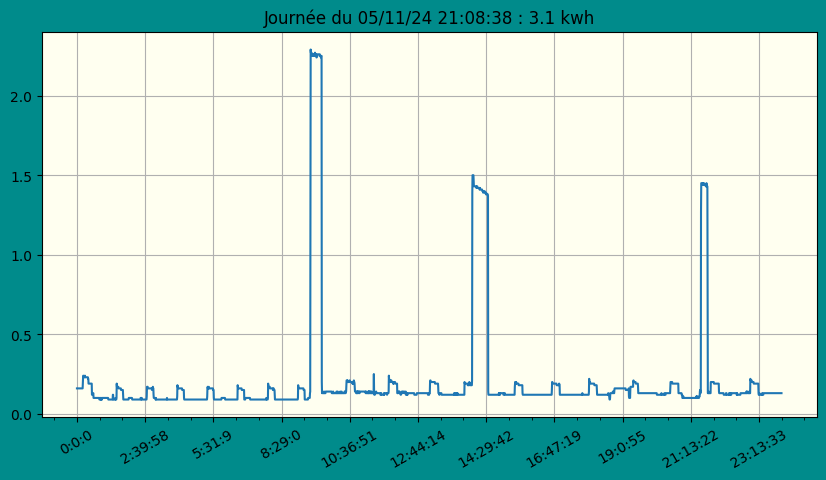

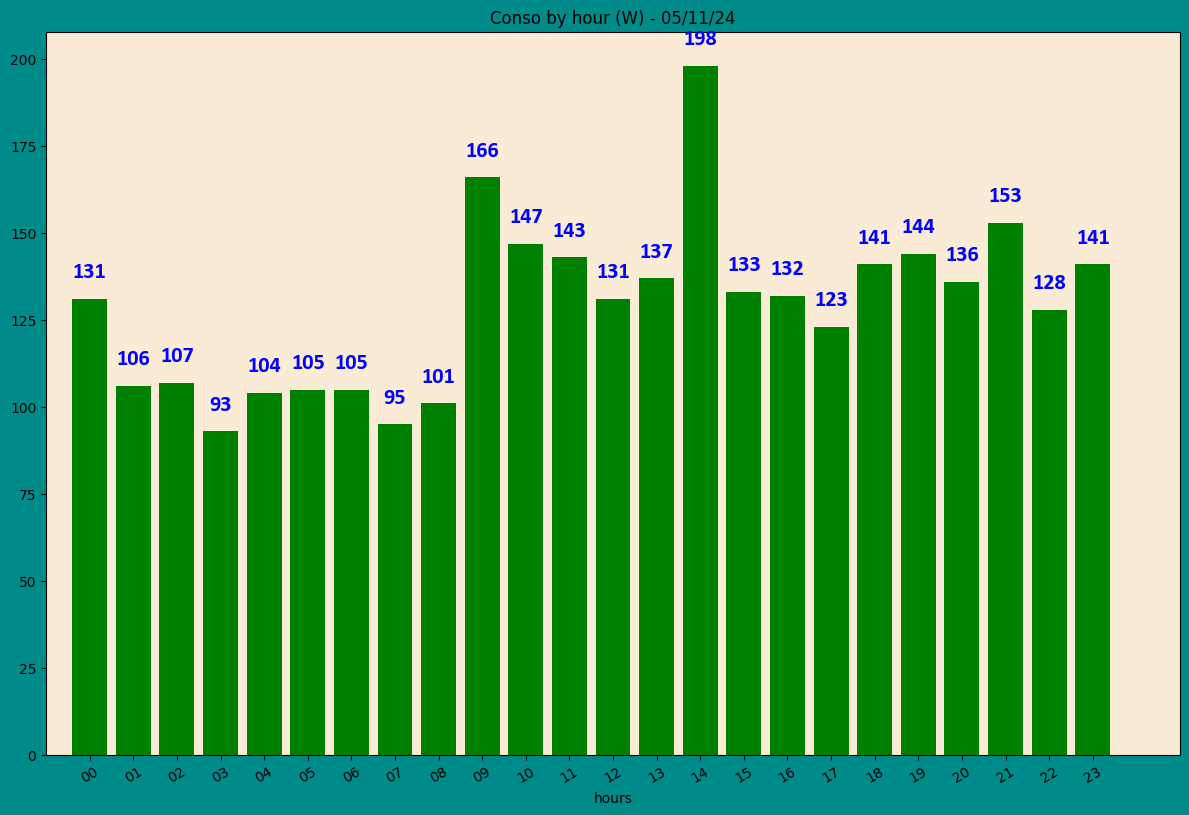

In [143]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [144]:
month

,day,hours,months,kWh
823305,01,00,2025-02,0.24
823306,01,00,2025-02,0.23
823307,01,00,2025-02,0.23
823308,01,00,2025-02,0.23
823309,01,00,2025-02,0.23
...,...,...,...,...
927763,28,23,2025-02,0.17
927764,28,23,2025-02,0.13
927765,28,23,2025-02,0.11
927766,28,23,2025-02,0.11


In [145]:
month.describe()


,kWh
count,104463.000000
mean,0.334575
std,0.555156
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

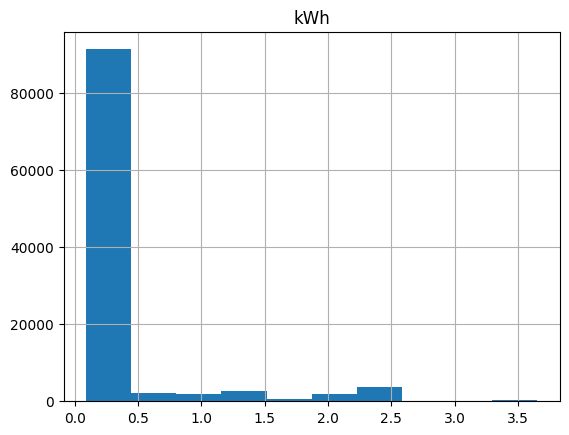

In [146]:
month.hist()

<Axes: >

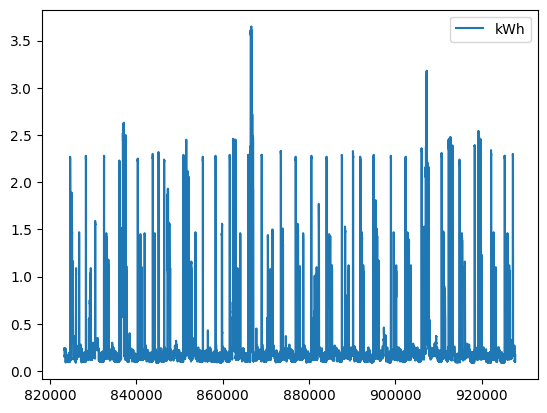

In [147]:
month.plot()

In [148]:
# index with max conso in this month
month.idxmax().kWh

np.int64(866633)

In [149]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       924353
hours     826963
months    823305
kWh       866633
dtype: int64

In [150]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [151]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
23/05/24 12      72      72    NaN   NaN
         13     133     205   61.0   NaN
         14     132     337   -1.0   NaN
         15     131     468   -1.0   NaN
         16     136     604    5.0   NaN
...             ...     ...    ...   ...
20/03/25 17     145    2452   -5.0  18.0
         18     149    2601    4.0  19.0
         19     152    2753    3.0  20.0
         20     141    2894  -11.0  21.0
         21      25    2919 -116.0  22.0

[7234 rows x 4 columns]

In [152]:
month

,day,hours,months,kWh
823305,01,00,2025-02,0.24
823306,01,00,2025-02,0.23
823307,01,00,2025-02,0.23
823308,01,00,2025-02,0.23
823309,01,00,2025-02,0.23
...,...,...,...,...
927763,28,23,2025-02,0.17
927764,28,23,2025-02,0.13
927765,28,23,2025-02,0.11
927766,28,23,2025-02,0.11


In [153]:
month.idxmax()


day       924353
hours     826963
months    823305
kWh       866633
dtype: int64

In [154]:
month.loc[month.idxmax().kWh]


day            12
hours          13
months    2025-02
kWh          3.65
Name: 866633, dtype: object

In [155]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       114
          01       111
          02        98
          03       111
          04       111
          05       111
          06        97
          07       110
          08       161
          09       143
          10       134
          11       148
          12       144
          13       200
          14       147
          15       184
          16       162
          17       147
          18       142
          19       168
          20       226
          21       173
          22       154
          23       119
Name: kWh, dtype: int64

In [156]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'20'

<Axes: xlabel='days,hours'>

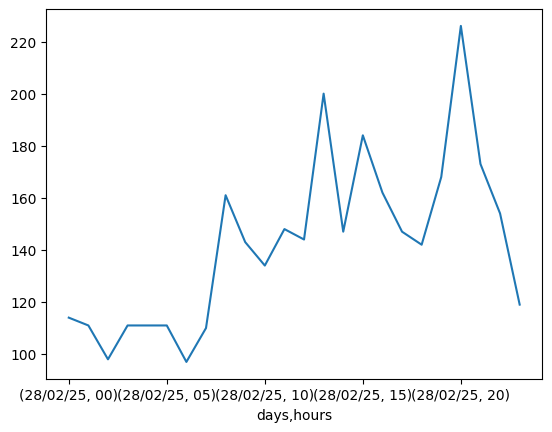

In [157]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [158]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [159]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [160]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [161]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB